<h1 style="text-align: center;"> Classification of Human Facial Expressions </h1>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Santiago Becerra Cordoba</strong>  
<br>
sab1475@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Sarah Kim</strong>  
<br>
gak604@g.harvard.edu
</div>


<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Chloe Seo</strong>  
<br>
yes593@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Kaylee Vo</strong>  
<br>
kav418@g.harvard.edu
</div>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Jie Zhao</strong>  
<br>
jiz273@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong></strong>  
<br>
</div>

<h5 style="text-align: center;"> ALM Data Science, Harvard University </h5>

## Table of Contents

1. [Introduction](#introduction)
    - [a. Access](#access)
    - [b. Load](#load)
    - [c. Understand](#understand)

2. [Preprocessing](#preprocessing)
    - [a. Missing Data](#missing-data)
    - [b. Data Imbalance](#data-imbalance)
    - [c. Denoising](#denoising)
    - [d. Feature Scaling](#feature-scaling)

3. [Sources](#sources)

4. [Appendix](#appendix)


## Data Overview

In this project, we aim to classify human facial expressions using a dataset of images. The data we will use is the FER-2013 dataset, which contains 35,887 grayscale images of size 48x48 pixels. Each image is labeled with one of seven emotions: anger, disgust, fear, happiness, sadness, surprise, and neutral. The data itself came with a train and test set. We split the train set into a train and validation set with 20% of the data going to the validation set.

The introduction has three sections: access, load, and understand. In the access section, we perform data engineering tasks to pull the data and prep the local directory structure. The data is too large to be kept in a repository, so this step is necessary for development. In the load section, we load the data into memory with Keras image generators. Finally in the Understand section, we sample a subset of images and present simple summaries and visualizations to better understand the data.

### Access

For this section we import libraries and write code to automatically pull the data from the internet. The code fetches from Kaggle and stores it in the users' cache. The code that moves the data from the cache to the project directory.

In [1]:
import os
import pathlib
import time
import zipfile
import random
import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import time
import tarfile
import gdown
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm
import shutil
import platform
import kagglehub

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

In [2]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Path to dataset files: /Users/kayleeyvo/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [3]:
DATA_DIR = os.getcwd() + "/data"

# For mac users
if platform.system() == "Darwin":
    os.system('find . -name ".DS_Store" -delete')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [4]:
if not os.path.exists(path):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)

        if os.path.isfile(item_path):
            shutil.copy(item_path, DATA_DIR)
            print(f"Copied file: {item_path}")
        elif os.path.isdir(item_path):
            shutil.copytree(item_path, os.path.join(DATA_DIR, item))
            print(f"Copied directory: {item_path}")

### Load

The data was already given in a directory structure. We leverage this in order loading code. After a 20% validaiton split, we have 22968 images in the training set, 5741 images in the validation set, and 7178 images in the test set. The total number of images is 35887. The images are scaled by dividing by 255. Note this is arbitrary for now and may be adjusted in the future.

In [5]:
train_dir = DATA_DIR + "/train"
val_dir = DATA_DIR + "/validation"
val_split = 0.2

if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        val_class_path = os.path.join(val_dir, class_name)
        os.makedirs(val_class_path, exist_ok=True)

        # List all images in the class directory
        images = os.listdir(class_path)
        random.shuffle(images)

        # Move a portion of images to validation
        num_val = int(len(images) * val_split)
        for img in images[:num_val]:
            shutil.move(
                os.path.join(class_path, img), os.path.join(val_class_path, img)
            )

In [6]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

In [7]:
batch_size = 32
target_size = (48, 48)  # generator can resize all images if we want

traingen = datagen.flow_from_directory(
    DATA_DIR + "/train",  # this is the target directory
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)
valgen = datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

testgen = datagen.flow_from_directory(
    DATA_DIR + "/test",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
total_images = traingen.samples + valgen.samples + testgen.samples

print("Total images in dataset:", total_images)

Total images in dataset: 35887


### Understand

The batch size is set to 32 but this is arbitrary and is subject to change. The dimensions of the images are 48x48 with a single channel (e.g. grayscale images). The number of classes is 7, corresponding to the 7 emotions. The mapping from integer to emotion is shown in a cell below. We also present a set of 8 images to preview the data. The images match well with their labels. One aspect to note is the existence of watermarks in some of the images. This is a potential source of noise in the data that will need to be addressed in the preprocessing step.

In [9]:
data_batch, labels_batch = next(traingen)
print("data batch shape:", data_batch.shape)
print("labels batch shape:", labels_batch.shape)

data batch shape: (32, 48, 48, 1)
labels batch shape: (32,)


In [10]:
class_indices = traingen.class_indices
class_labels = {v: k for k, v in class_indices.items()}

In [11]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

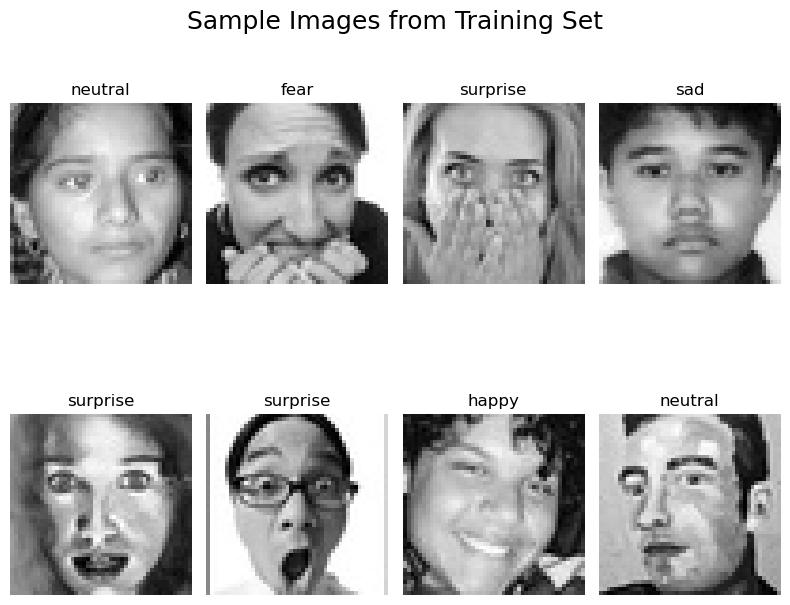

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(8, 8))

axs = ax.ravel()

counter = 0
for batch, labels in traingen:
    for img, label in zip(batch, labels):
        class_index = int(label)
        class_name = class_labels[class_index]

        axs[counter].imshow(img[:, :, 0], cmap="gray")
        axs[counter].set_title(class_name)
        axs[counter].axis("off")

        counter += 1
        if counter >= 8:
            break

    break

plt.suptitle("Sample Images from Training Set", y=0.9, fontsize=18)
plt.tight_layout()

## Preprocessing

### Missing Data

In [13]:
traingen.reset()
testgen.reset()

missing_count_train = 0
total_pixels_train = 0
missing_count_test = 0
total_pixels_test = 0

for i in range(len(traingen)):
    batch_images, batch_labels = next(traingen)
    missing_count_train += np.isnan(batch_images).sum()
    total_pixels_train += batch_images.size

for i in range(len(testgen)):
    batch_images, batch_labels = next(testgen)
    missing_count_test += np.isnan(batch_images).sum()
    total_pixels_test += batch_images.size

print("--Training Set--")
print(f"Missing pixel values: {missing_count_train}")
print(f"Total pixels:         {total_pixels_train}")
if total_pixels_train > 0:
    pct_train = (missing_count_train / total_pixels_train) * 100
    print(f"Percentage missing:   {pct_train:.2f}%")
else:
    print("No pixels found")

print("\n--Test Set--")
print(f"Missing pixel values: {missing_count_test}")
print(f"Total pixels:         {total_pixels_test}")
if total_pixels_test > 0:
    pct_test = (missing_count_test / total_pixels_test) * 100
    print(f"Percentage missing:   {pct_test:.2f}%")
else:
    print("No pixels found")

if missing_count_train == 0 and missing_count_test == 0:
    print(
        "\nObservation: There are no missing pixel values in either training or test sets. "
    )
else:
    print("\nObservation: Some missing pixel values were found.")

--Training Set--
Missing pixel values: 0
Total pixels:         52918272
Percentage missing:   0.00%

--Test Set--
Missing pixel values: 0
Total pixels:         16538112
Percentage missing:   0.00%

Observation: There are no missing pixel values in either training or test sets. 


Checked through the training (traingen) and test (testgen) datasets for any missing pixel values by looping through every image batch and counting NaNs. As a result, there were no missing pixels found. 

### Data Imbalance

The training set shows clear class imbalance:

- **Underrepresented**:
  - *Disgust* (fewer than 1,000 images)
  - *Surprise*
- **Overrepresented**:
  - *Happy* (nearly 6,000 images)

This imbalance can bias the model toward majority classes and reduce accuracy on minority ones like *disgust* and *surprise*. To improve robustness and generalization, we applied data augmentation (e.g., rotation, zoom, flipping) to the entire training set. While this doesn’t rebalance class frequency, it helps prevent overfitting and exposes the model to more varied inputs.

If this approach proves insufficient, we’ll explore more targeted strategies—such as oversampling underrepresented classes or applying heavier augmentation selectively.

Additionally, we computed `class_weight` values to be used during model training. These weights adjust the loss function to penalize misclassifications of rare classes more heavily. For example, *disgust* has a weight of **9.4**, while *happy* has a weight of **0.57**. This encourages the model to pay more attention to minority classes during learning.

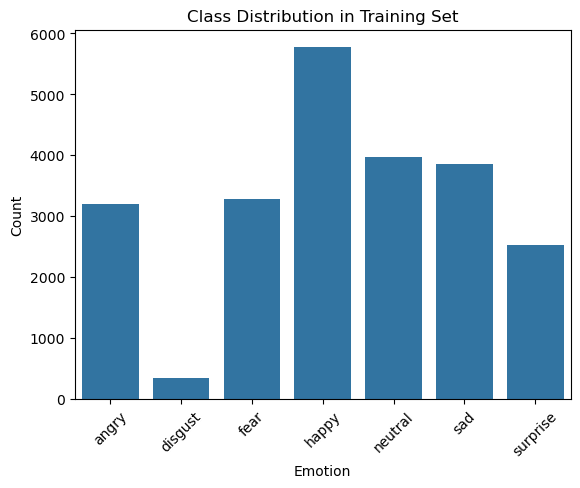

In [14]:
# Check if there is class imbalance
# Get class labels from traingen (not just a batch but all)
labels = traingen.classes
class_indices = traingen.class_indices
class_labels = {v: k for k, v in class_indices.items()}

label_names = [class_labels[label] for label in labels]
sns.countplot(x=label_names, order=sorted(set(label_names)))
plt.title("Class Distribution in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [15]:
# Add added data augmentation to train dataset to improve robustness
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# keep the rescale only for validation & test data
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [16]:
# Update the generator
traingen = train_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

valgen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

testgen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/test",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [17]:
# Add class weight

labels = traingen.classes
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(labels), y=labels
)
class_weights_dict = dict(enumerate(class_weights))

print(
    "Class weights:", class_weights_dict
)  # we could use this class_weight when we fit the model

Class weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


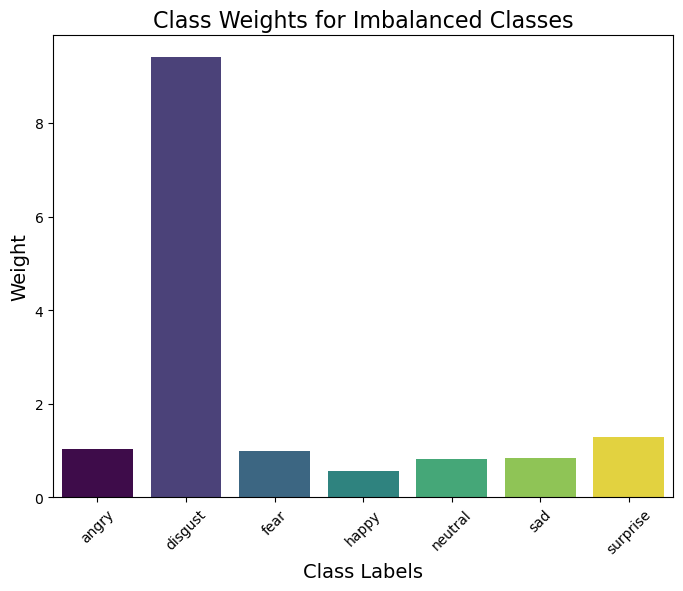

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

labels, values = list(class_weights_dict.keys()), list(class_weights_dict.values())
sns.barplot(x=labels, y=values, hue=labels, palette="viridis")
ax.legend_.remove()
ax.set_xticks(labels, labels=class_labels.values(), rotation=45)

ax.set_title("Class Weights for Imbalanced Classes", fontsize=16)
ax.set_ylabel("Weight", fontsize=14)
ax.set_xlabel("Class Labels", fontsize=14)
plt.show()

As expected, the class weights are inversely proportional to the number of samples in each class. The class weights for `digust` are the largest, while the class weights for `happy` are the smallest. 

### Denoising

#### Approach 2: Non-Local Means Denoising

Non-local means (NLM) is a denoising technique that differs from local filters by considering the entire image for noise reduction. It does so by computing a mean for all pixels in the image, weighted by how similar these pixels are to the target pixel. We attempt to apply this technique to alleviate the water mark issue seen in some of the images. We use OpenCV library which can easily be integrated into tensorflow via a custom layer. We hand pick a set of four images to test this denoising approach. A thorough formulation of this approach can be found in the Appendix.

In [122]:
import cv2

In [ ]:
surprise_watermarked_images = [
    "surprise/Training_1047709.jpg",
    "surprise/Training_343893.jpg",
    "sad/Training_8765621.jpg",
    "sad/Training_3685370.jpg",
]

In [ ]:
def read_image(path):
    watermark_img_bytes = tf.io.read_file(path)
    watermark_image_tensor = tf.image.decode_image(watermark_img_bytes, channels=3)

    return watermark_image_tensor

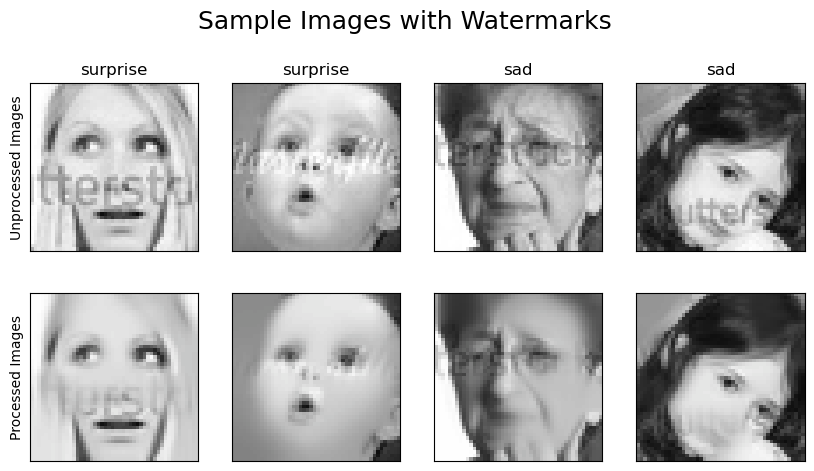

In [222]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

counter = 0

for image_path in surprise_watermarked_images:
    image = read_image("./data/train/" + image_path)
    axs[0, counter].imshow(image, cmap="gray")
    axs[0, counter].set_title(image_path.split("/")[0])

    denoised_image = cv2.fastNlMeansDenoisingColored(
        image.numpy(),
        None,
        # Strength of the filter
        h=10,
        # Size in pixels of the template patch that is used to compute weights.
        templateWindowSize=9,
        # Size in pixels of the window that is used to compute weighted average for given pixel
        searchWindowSize=21,
    )
    axs[1, counter].imshow(denoised_image, cmap="gray")

    if counter == 0:
        axs[0, 0].set_ylabel("Unprocessed Images")
        axs[1, 0].set_ylabel("Processed Images")

    axs[0, counter].set_xticks([])
    axs[0, counter].set_yticks([])
    axs[1, counter].set_xticks([])
    axs[1, counter].set_yticks([])

    counter += 1

plt.suptitle("Sample Images with Watermarks", y=1.02, fontsize=18)
plt.show()

The results are decent but as expected there is a tradeoff. We lose image detail when we apply NLM. The watermark is less visible but the image is also less clear. It remains to be determined if the watermark even has a significant impact on future model performance. The strategy going forward will be to train a model without any denoising and then try a model with Gaussian denoising and NLM. If both strategies fail, we will try to use autoencoders to remove the watermark. We will use the watermarked image and the denoised image as training pairs to hopefully create images that are more clear. A simple example of this is found in Lab 6 using Gaussian blur.

In [ ]:
# TODO
# - Probably the most difficult
# - We need to at least have one strategy implemented that can reduce the visual impact of the 'shutterstock' watermarks (don)
# - Code to show examples of watermark (done)
# - Apply gaussian blur, non-local means (done)
# - Show that the issue is resolved (done)
# - Few sentences explaining approach and results (done)

### Feature Scaling

In [ ]:
# TODO
# - Dividing by 255 is standard maybe a quick experiment with standard scaler would be helpful
# - This can be done in conjunction with the baseline model

### Summary

- one paragraph summary of the preprocessing steps.
- a few sentences on future work

## Baseline Model

In [ ]:
# As a sanity check
# Traceplots: one using division by 255 and the other using standard scaler
# - Few sentences explaining approach and results

## Sources

1. https://en.wikipedia.org/wiki/Non-local_means
2. https://docs.opencv.org/3.4/d1/d79/group__photo__denoise.html#ga03aa4189fc3e31dafd638d90de335617

## Appendix

### Mathematical Formulae

For our case, since we use normalization our pixel values are continous. The NLM algorithm is defined as the following transformation. Let $u(p)$ be the transformed pixel value at position $p$ in the image. $C(p)$ is a normalizing constant and $\Omega$ is the set of pixels in the image. $v(q)$ is the untransformed pixel.

$$
u(p) = \frac{1}{C(p)} \int_{q \in \Omega} v(q) \cdot w(p,q) dq
$$

The weight function $w(p,q)$ is defined as follows:

$$
w(p,q) = exp(- \frac{|B(q) - B(p)|^2}{h^2}).
$$

$h$ is the parameter we pass into the NLM function. It controls the strength of the denoising. A larger value of $h$ means more smoothing and less detail. $B(p)$ is a patch of pixels around the pixel p. The size of the patch is defined by the parameter `templateWindowSize`. $B(q)$ is a patch of pixels around the pixel q. The size of the patch is defined by the parameter `searchWindowSize`. The weight measures how similar the patches $B(p)$ and $B(q)$ are. The weight will be larger if the patches are more similar.
